# Analyse des prix des actions de l'Entreprise Amazon
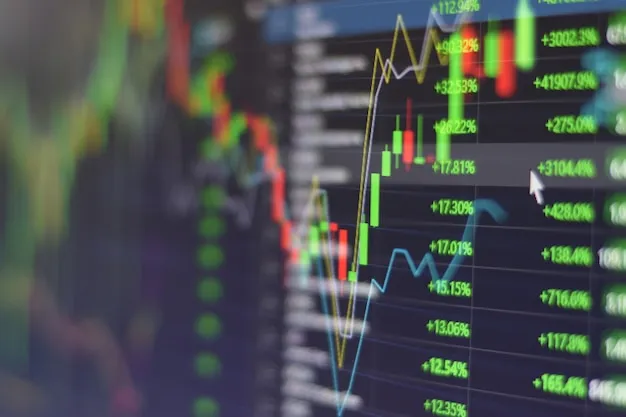






#Introduction

Dans le domaine de la finance, la capacité à prédire les fluctuations des prix des actions est cruciale pour les investisseurs, les traders et les analystes. Les avancées technologiques et l'essor de l'apprentissage automatique ont ouvert la voie à de nouvelles approches pour modéliser et prédire ces mouvements de marché avec une précision accrue. Dans ce contexte, notre projet se concentre sur la simulation et la prédiction des prix des actions d'Amazon, l'une des plus grandes sociétés technologiques au monde, en utilisant deux techniques puissantes : les modèles LSTM (Long Short-Term Memory) et ARIMA (AutoRegressive Integrated Moving Average).

**Objectif du Projet**

L'objectif principal de ce projet est de développer des modèles de prévision des prix d'actions d'Amazon qui peuvent capturer les tendances complexes et les schémas de comportement du marché financier. Pour ce faire, nous allons :

1. Collecter des données historiques détaillées sur les prix de clôture des actions d'Amazon sur une période étendue.
2. Explorer et prétraiter ces données pour en extraire des informations significatives et éliminer les bruits indésirables.
3. Mettre en œuvre deux approches distinctes pour la modélisation et la prédiction :
    - Le modèle ARIMA, qui est efficace pour modéliser les tendances et les saisons dans les séries temporelles.
    - Le modèle LSTM, un type de réseau de neurones récurrents (RNN) capable de capturer les dépendances à long terme dans les données séquentielles.
4. Comparer les performances des deux modèles en termes de précision de prédiction et de capacité à saisir les variations complexes du marché.
5. Fournir une simulation des prix d'actions d'Amazon basée sur les modèles développés, offrant ainsi des informations utiles pour les décideurs financiers.




# Nouvelle section

In [ ]:
pip install tensorflow

In [ ]:
pip install pmdarima

#importation des bibliothéque

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib.dates as mdates


from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima



*DATA*


**Date**: La date à laquelle les données ont été enregistrées. \\
**Open**: Le prix d'ouverture du marché financier à la date donnée.

**High**: Le prix le plus élevé atteint sur le marché financier au cours de la période donnée.

**Low**: Le prix le plus bas atteint sur le marché financier au cours de la période donnée.

**Close**: Le prix de clôture du marché financier à la date donnée.

**Adj Close**: Le prix de clôture ajusté pour tenir compte de tout événement tel que les dividendes, les émissions d'actions, etc.

**Volume**: Le volume d'activité ou le nombre total d'actions échangées sur le marché financier à la date donnée.

In [ ]:
path = "/content/AMZN.csv"
data = pd.read_csv(path)
cm = sns.light_palette("green", as_cmap=True)
data.head(30).style.background_gradient(cmap=cm)

,Date,Open,High,Low,Close,Adj Close,Volume
0,15/05/1997,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,16/05/1997,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,19/05/1997,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,20/05/1997,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,21/05/1997,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
5,22/05/1997,1.437500,1.447917,1.312500,1.395833,1.395833,11776800
6,23/05/1997,1.406250,1.520833,1.333333,1.500000,1.500000,15937200
7,27/05/1997,1.510417,1.645833,1.458333,1.583333,1.583333,8697600
8,28/05/1997,1.625000,1.635417,1.531250,1.531250,1.531250,4574400
9,29/05/1997,1.541667,1.541667,1.479167,1.505208,1.505208,3472800


In [ ]:
pd.DataFrame(data.columns, columns=["name"])

,name
0,Date
1,Open
2,High
3,Low
4,Close
5,Adj Close
6,Volume


## **Data Processing**

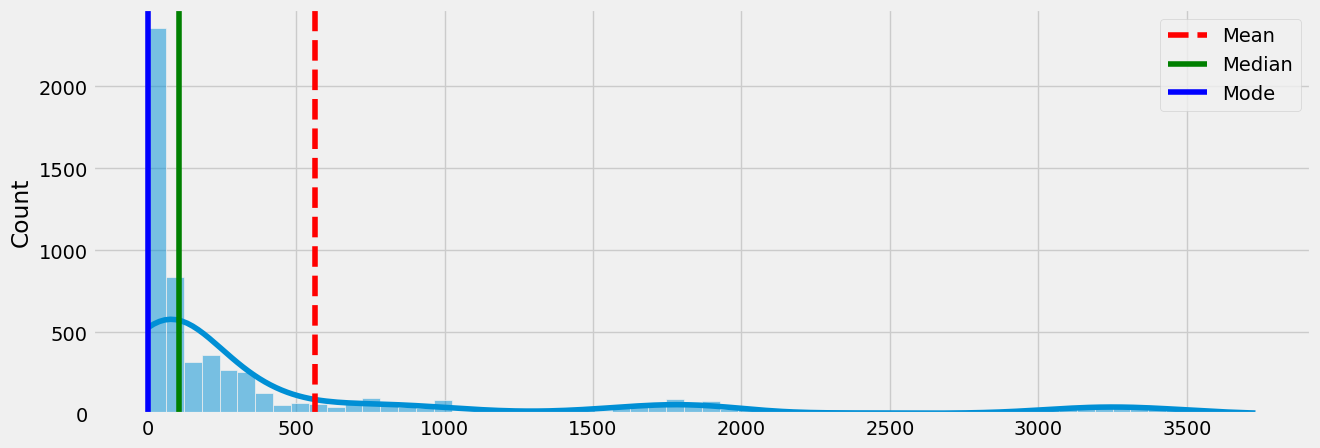

In [ ]:
f, (ax1) = plt.subplots(1, 1, figsize=(14, 5))
v_dist_1 = data["Close"].values
sns.histplot(v_dist_1, ax=ax1, kde=True)
mean=data["Close"].mean()
median=data["Close"].median()
mode=data["Close"].mode().values[0]
ax1.axvline(mean, color='r', linestyle='--', label="Mean")
ax1.axvline(median, color='g', linestyle='-', label="Median")
ax1.axvline(mode, color='b', linestyle='-', label="Mode")
ax1.legend()

In [ ]:
fig = px.bar(data, x='Date', y='Volume')
fig.update_layout(title=f'Amazon stock price', barmode='stack', font_color="red")
fig.show()

In [ ]:
# Déterminer l'indice à partir duquel commencer la partie de test
test_start_index = len(data) - 252

# Diviser les données en parties d'entraînement et de test
train_data = data.iloc[:test_start_index]  # Sélectionner toutes les lignes jusqu'à l'indice de début de test
test_data = data.iloc[test_start_index:]   # Sélectionner toutes les lignes à partir de l'indice de début de test jusqu'à la fin

# Afficher les tailles des parties d'entraînement et de test
print("Taille de l'ensemble d'entraînement:", len(train_data))
print("Taille de l'ensemble de test:", len(test_data))


Taille de l'ensemble d'entraînement: 6005
Taille de l'ensemble de test: 252


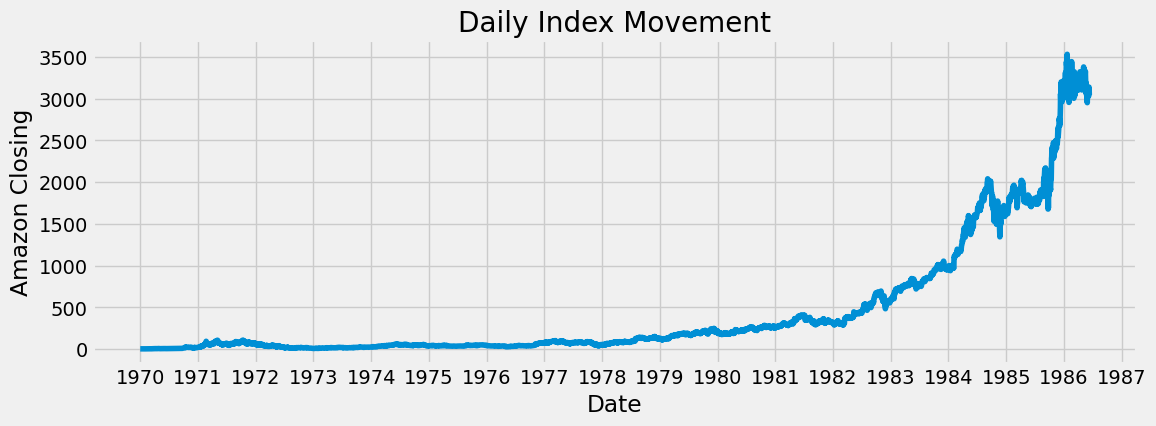

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train_data['Date'], train_data['Close'])
ax.set(xlabel='Date', ylabel='Amazon Closing', title='Daily Index Movement')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format de l'année

plt.show()


# Simulation Monte Carlo
Les simulations de Monte Carlo sont un outil incroyablement puissant dans de nombreux contextes, y compris la recherche opérationnelle, la théorie des jeux, la physique, les affaires et la finance, entre autres. C'est une technique utilisée pour comprendre l'impact du risque et de l'incertitude lors de la prise de décision. En termes simples, une simulation de Monte Carlo exécute un nombre énorme d'essais avec différents nombres aléatoires générés à partir d'une distribution sous-jacente pour les variables incertaines.

Ici, nous allons plonger dans la manière de prédire les prix des actions en utilisant une simulation de Monte Carlo !

Que devons-nous comprendre avant de commencer ?

Nous voulons prédire le prix de l'action aujourd'hui. Nous connaissons le prix de l'action hier. Alors, qu'est-ce qui manque ? Nous ne connaissons évidemment pas le rendement quotidien que l'action va générer aujourd'hui. C'est là que Monte Carlo intervient ! Mais d'abord... comment pouvons-nous estimer le rendement ?

Comment prévoyons-nous le rendement quotidien de l'action ? Mouvement Brownien.

Le mouvement brownien sera le principal moteur pour estimer le rendement. C'est un processus stochastique utilisé pour modéliser le comportement aléatoire au fil du temps. Le mouvement brownien a deux composantes principales :

- Dérive — la direction que les taux de rendement ont eue dans le passé. Autrement dit, le rendement attendu de l'action. Vous pouvez vous demander : pourquoi la variance est-elle multipliée par 0,5 ? Parce que les valeurs historiques sont érodées dans le futur.
- Volatilité — la volatilité historique multipliée par une variable normale standard aléatoire.

\begin{equation}
S_t = S_{t-1} \times e^{(r - \frac{\sigma^2}{2})\Delta t + \sigma \sqrt{\Delta t} Z}
\end{equation}

\begin{align*}
\text{Drift} & = \mu  \\
\text{Volatility} & = \sigma \cdot Z \\
r & = (\mu ) \cdot \left(1 + \sigma^2\right) + \sigma \cdot Z \\
S_t & = S_{t-1} \times e^{\left(\mu \right) + 0.02 \cdot \sqrt{Z}}
\end{align*}



Dans cette équation :

\( S_t \) représente le prix de l'action à l'instant \( t \),

\( S_{t-1} \) représente le prix de l'action à l'instant précédent \( t-1 \),

\( r \) est le taux de dérive,

\( \sigma \) est la volatilité,

\( \Delta t \) est l'intervalle de temps entre les périodes de simulation,

\( Z \) est un nombre aléatoire issu d'une distribution normale standard.








In [ ]:
# Calculer les rendements logarithmiques pour chaque variable
train_data['Log_return']=np.log(train_data['Close'] / train_data['Close'].shift(1))

# Calculer le drift et la volatilité pour chaque variable
drift = train_data["Log_return"].mean()
volatility = train_data["Log_return"].std()

# Définir les paramètres de simulation
T = 252  # Nombre de jours à simuler
N = 1000  # Nombre de simulations

# Générer les simulations de prix pour chaque variable
simulated_prices_train= pd.DataFrame()
simulated_prices_train = np.zeros((T, N))
simulated_prices_train[0, :] = train_data['Close'].iloc[-1]  # La première valeur est la valeur actuelle

for t in range(1, T):
       Z = np.random.lognormal((drift - 0.5 * volatility**2), volatility, N)
       simulated_prices_train[t, :] = simulated_prices_train[t-1,:] * Z


# Afficher les premières lignes des données simulées
print(simulated_prices_train)

[[3046.26001    3046.26001    3046.26001    ... 3046.26001
  3046.26001    3046.26001   ]
 [3030.18581299 2941.39868306 3104.02122934 ... 3185.43756882
  3064.5633842  3006.28398805]
 [3272.73130479 2869.64109495 3262.58301327 ... 3139.16065502
  3003.33656334 3030.33801561]
 ...
 [2818.06813104 4207.47566501 6386.6590137  ... 4393.04578384
  2468.45691882 3548.79801584]
 [3002.07060832 4071.34345315 7017.15988502 ... 4168.46139629
  2383.52223477 3222.31765722]
 [3000.80318197 4006.22397729 7026.58510138 ... 4394.41864518
  2200.74989711 3200.54413156]]


In [ ]:
simulated_prices_train=pd.DataFrame(simulated_prices_train)

print(simulated_prices_train)

             0            1            2            3            4    \
0    3046.260010  3046.260010  3046.260010  3046.260010  3046.260010   
1    3030.185813  2941.398683  3104.021229  3096.882979  3176.884922   
2    3272.731305  2869.641095  3262.583013  2901.914730  3343.337327   
3    3132.767090  2982.236238  3259.999381  2738.125710  3103.065880   
4    3163.632032  3014.896754  3232.783513  2771.071339  3401.382826   
..           ...          ...          ...          ...          ...   
247  3032.854546  4604.067748  6410.851019  7476.555282  4098.917295   
248  3002.626312  4446.305954  6346.577683  7482.197173  3869.463655   
249  2818.068131  4207.475665  6386.659014  7473.176880  3889.783671   
250  3002.070608  4071.343453  7017.159885  7532.194605  3786.792494   
251  3000.803182  4006.223977  7026.585101  7499.001840  3951.323397   

             5            6            7             8            9    ...  \
0    3046.260010  3046.260010  3046.260010   3046.260010 

In [ ]:
def calculate_mape(actual_values, forecast_values):
    errors = []
    for actual, forecast in zip(actual_values, forecast_values):
        absolute_error = abs(actual - forecast)
        relative_error = absolute_error / actual
        errors.append(relative_error)
    mape = np.mean(errors) * 100
    return mape

# Initialiser un DataFrame pour stocker les métriques
metrics_df = pd.DataFrame(columns=['Simulation', 'RMSE', 'MAE', 'MAPE'])

# Parcourir chaque colonne de votre tableau de simulations
for i, col in enumerate(simulated_prices_train.columns):
    # Comparer les valeurs prédites avec les valeurs réelles dans test_data
    true_values = test_data['Close'].values  # Supposons que la vraie valeur est dans la colonne 'Close'
    predicted_values = simulated_prices_train[col].values

    # Calculer les métriques d'évaluation
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mae = mean_absolute_error(true_values, predicted_values)
    mape = calculate_mape(true_values, predicted_values)

    # Ajouter les résultats au DataFrame des métriques
    metrics_df.loc[i] = [i, rmse, mae, mape]

# Afficher le DataFrame des métriques
print(metrics_df)


     Simulation         RMSE          MAE       MAPE
0           0.0  1119.449844   995.057760  29.407707
1           1.0  1029.469075   772.014120  24.078044
2           2.0  1575.883263  1204.359682  37.460404
3           3.0  2385.946105  1752.671407  55.211802
4           4.0   618.714401   477.605845  14.580954
..          ...          ...          ...        ...
995       995.0  1530.095933  1422.946638  42.468882
996       996.0   874.599342   777.820490  23.395038
997       997.0  1055.920567   904.600863  27.660386
998       998.0   958.065021   892.043633  26.490842
999       999.0   659.383837   521.081173  15.439186

[1000 rows x 4 columns]


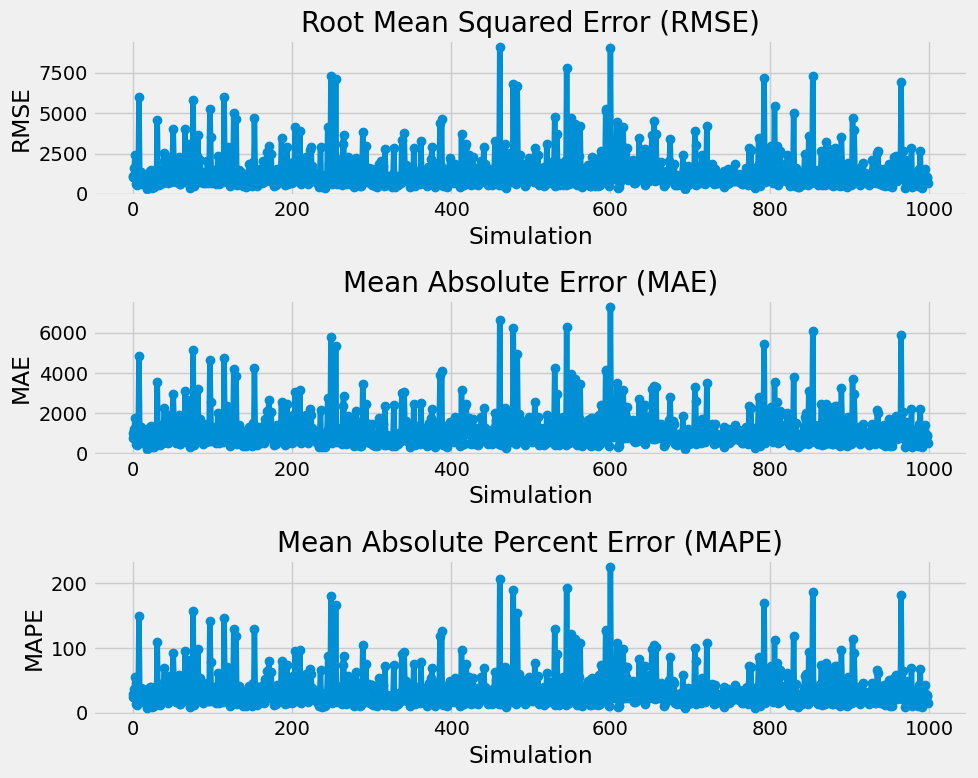

In [ ]:
# Créer une figure et des sous-graphiques
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# Tracer RMSE
axes[0].plot(metrics_df['Simulation'], metrics_df['RMSE'], marker='o', linestyle='-')
axes[0].set_title('Root Mean Squared Error (RMSE)')
axes[0].set_xlabel('Simulation')
axes[0].set_ylabel('RMSE')

# Tracer MAE
axes[1].plot(metrics_df['Simulation'], metrics_df['MAE'], marker='o', linestyle='-')
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xlabel('Simulation')
axes[1].set_ylabel('MAE')

# Tracer MAPE
axes[2].plot(metrics_df['Simulation'], metrics_df['MAPE'], marker='o', linestyle='-')
axes[2].set_title('Mean Absolute Percent Error (MAPE)')
axes[2].set_xlabel('Simulation')
axes[2].set_ylabel('MAPE')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()


In [ ]:
# Trouver l'indice de la simulation avec le minimum de RMSE et min de MAPE
min_mape_index = metrics_df['MAPE'].idxmin()
min_rmse_index = metrics_df['RMSE'].idxmin()


In [ ]:
min_rmse_value=metrics_df['RMSE'].min()
min_mape_value = metrics_df['MAPE'].min()
print("la moyenne des RMSE",metrics_df['RMSE'].mean())
print('#########################################################')
print("la moyenne des MAE",metrics_df['MAE'].mean())
print('#########################################################')
print("la valeur minimal de MAPE : ",min_mape_value)
print('#########################################################')
print("la valeur minimal de RMSE : ",min_rmse_value)

la moyenne des RMSE 1391.0149876070009
#########################################################
la moyenne des MAE 1145.9602007567707
#########################################################
la valeur minimal de MAPE :  6.92295714728947
#########################################################
la valeur minimal de RMSE :  296.15525627923904


In [ ]:
metrics_df[metrics_df['Simulation']==min_mape_index]

,Simulation,RMSE,MAE,MAPE
694,694.0,296.155256,229.224949,6.922957


# Model LSTM :


In [ ]:
# Normalize data
train_data=train_data.filter(['Close'])
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.fit_transform(simulated_prices_train[min_mape_index].to_frame())


# LSTM data preparation
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 1
X_train, y_train = create_dataset(train_scaled, time_steps)
X_test, y_test = create_dataset(test_scaled, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, X_test.shape[1]))


In [ ]:
# Build and train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=2)

# Make predictions with LSTM model
lstm_train_predict = lstm_model.predict(X_train)
lstm_test_predict = lstm_model.predict(X_test)

# Inverse transform predictions
lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])


Epoch 1/10
94/94 - 5s - loss: 0.0369 - 5s/epoch - 48ms/step
Epoch 2/10
94/94 - 0s - loss: 0.0124 - 497ms/epoch - 5ms/step
Epoch 3/10
94/94 - 0s - loss: 8.0204e-04 - 406ms/epoch - 4ms/step
Epoch 4/10
94/94 - 0s - loss: 9.8224e-05 - 486ms/epoch - 5ms/step
Epoch 5/10
94/94 - 0s - loss: 9.3537e-05 - 340ms/epoch - 4ms/step
Epoch 6/10
94/94 - 0s - loss: 8.8079e-05 - 355ms/epoch - 4ms/step
Epoch 7/10
94/94 - 0s - loss: 8.3036e-05 - 498ms/epoch - 5ms/step
Epoch 8/10
94/94 - 1s - loss: 7.7436e-05 - 526ms/epoch - 6ms/step
Epoch 9/10
94/94 - 1s - loss: 7.2238e-05 - 592ms/epoch - 6ms/step
Epoch 10/10
94/94 - 0s - loss: 6.7378e-05 - 488ms/epoch - 5ms/step
8/8 [==============================] - 0s 3ms/step


**Interpretation**

un RMSE de 126.18 et un MAPE de 2.95 pour les données de test indiquent que le modèle produit des prédictions relativement précises, mais qu'il existe encore une certaine marge d'erreur à améliorer.

In [ ]:
# Evaluate LSTM
def evaluate_model(true, predicted):
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    return rmse, mape

lstm_train_rmse, lstm_train_mape = evaluate_model(y_train_inv[0], lstm_train_predict[:,0])
lstm_test_rmse, lstm_test_mape = evaluate_model(y_test_inv[0], lstm_test_predict[:,0])

In [ ]:
print("LSTM Train RMSE:", lstm_train_rmse)
print("LSTM Train MAPE:", lstm_train_mape)
print("LSTM Test RMSE:", lstm_test_rmse)
print("LSTM Test MAPE:", lstm_test_mape)

LSTM Train RMSE: 12.677071088410294
LSTM Train MAPE: 0.24989847746536226
LSTM Test RMSE: 118.02218828316562
LSTM Test MAPE: 2.8731370473759177


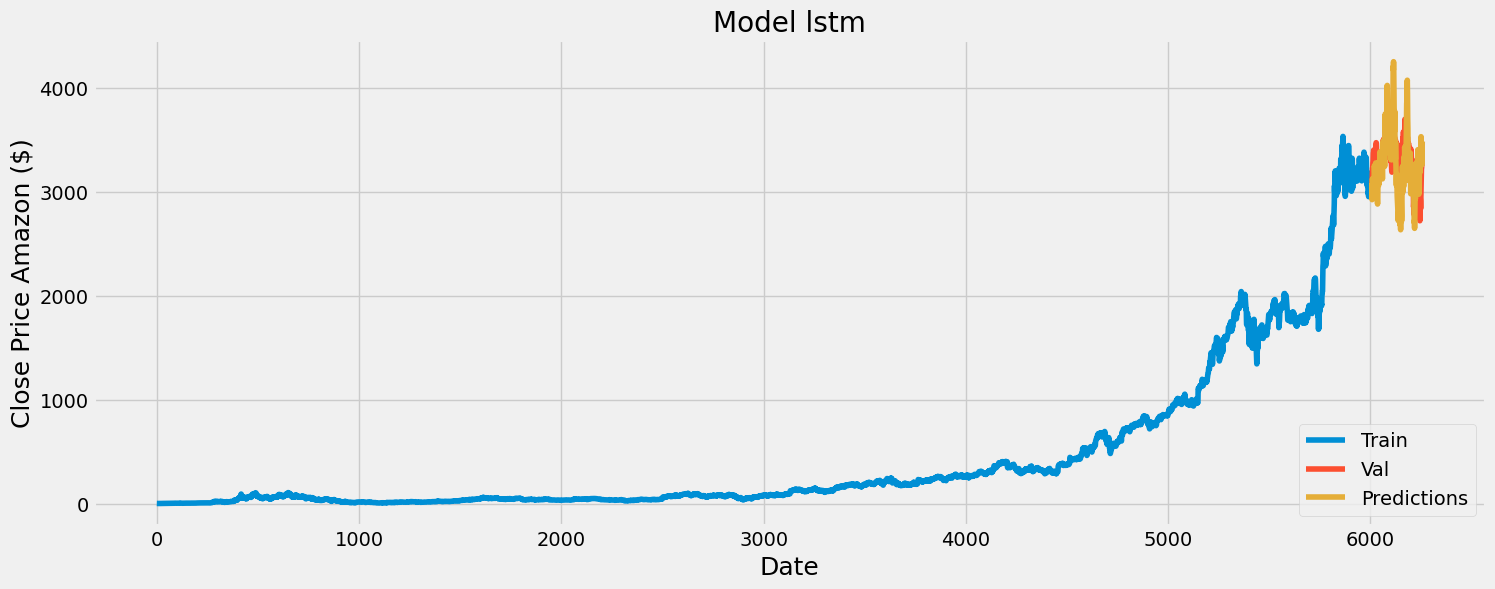

In [ ]:
train = data[:len(train_data)]
valid = data[len(train_data)+1:]
valid['Predictions'] = lstm_test_predict
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model lstm')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Amazon ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

#ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51374.823, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51354.739, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51354.605, Time=3.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51377.892, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=51347.908, Time=6.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=51348.478, Time=10.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=51349.902, Time=5.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=51356.369, Time=4.66 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=51356.737, Time=2.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=51338.037, Time=9.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=51312.146, Time=7.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=51312.267, Time=4.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=51287.394, Time=12.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=51298.406, Time=14.90 sec
 ARIMA(3,1,3)(0,

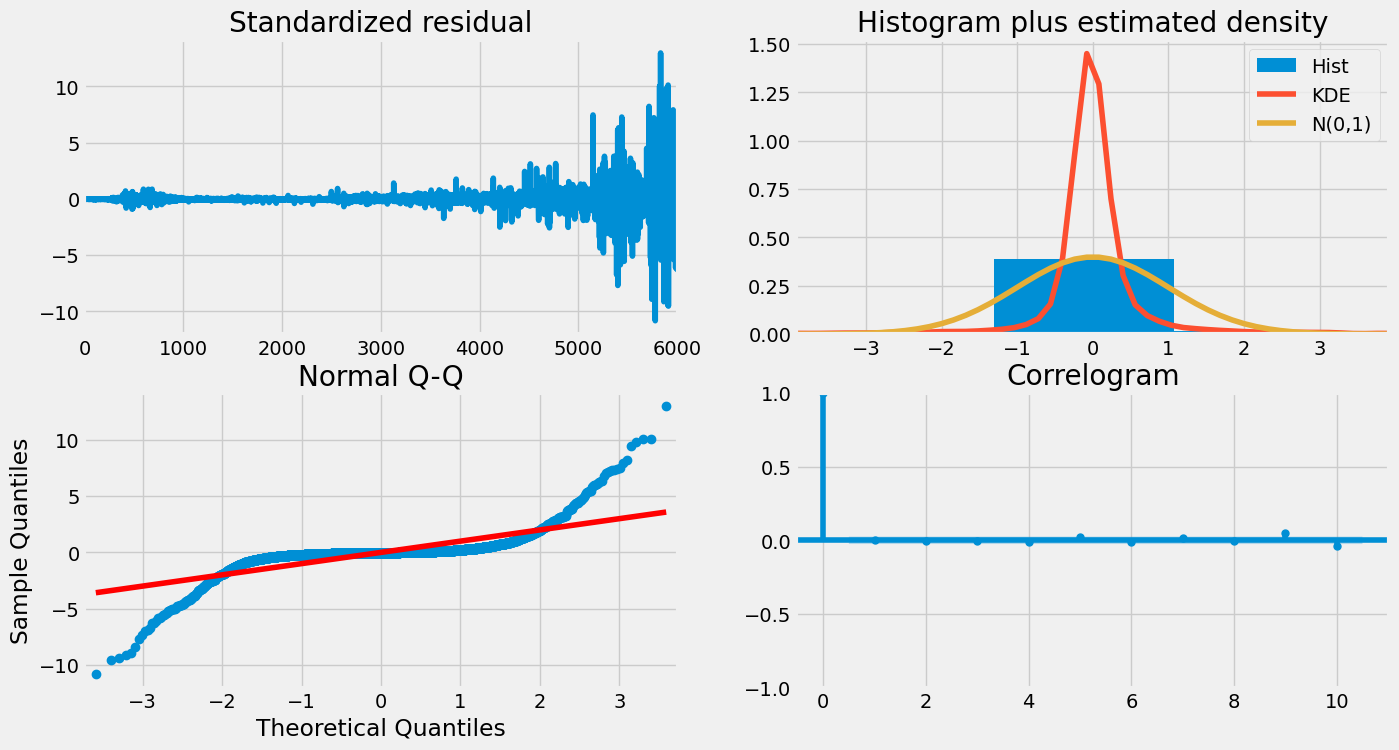

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

# **Interpretation**
**intercept (constante) :**

La valeur de l'intercept est de 0.6662 avec une erreur standard de 0.261.
Cela signifie qu'il y a une valeur constante ajoutée à la prédiction du modèle, indépendamment des autres variables.
L'intercept est statistiquement significatif car sa p-valeur est inférieure à 0,05, ce qui suggère qu'il y a un effet constant dans le modèle.

**Coefficients AR (AutoRegressive) :**

Les coefficients AR indiquent la contribution des valeurs précédentes de la série temporelle à la valeur actuelle.
Les coefficients pour AR(1), AR(2) et AR(3) sont respectivement -0.7411, 0.0448 et 0.3869.
Les valeurs significatives (avec une p-valeur inférieure à 0,05) indiquent une relation statistiquement significative entre les valeurs passées et la valeur actuelle de la série temporelle.

**Coefficients MA (Moving Average) :**

Les coefficients MA indiquent la contribution des erreurs passées à la valeur actuelle de la série temporelle.
Les coefficients pour MA(1), MA(2) et MA(3) sont respectivement 0.6826, -0.0846 et -0.4712.

Les valeurs significatives (avec une p-valeur inférieure à 0,05) indiquent une relation statistiquement significative entre les erreurs passées et la valeur actuelle de la série temporelle.

**sigma2 :**

La variance de l'erreur résiduelle (sigma2) est de 299.4888.
Cela représente la dispersion des données autour de la ligne de régression, ce qui signifie que les valeurs réelles peuvent varier d'environ 299 unités par rapport aux valeurs prédites par le modèle.

**Tests de diagnostic :**

Le test de Ljung-Box (L1) a une p-valeur de 0.78, ce qui indique qu'il n'y a pas de corrélation sérielle significative dans les résidus du modèle.
Le test de Jarque-Bera a une p-valeur de 0.00, ce qui suggère que la distribution des résidus n'est pas normale, ce qui peut indiquer une mauvaise spécification du modèle.

In [ ]:
#Modeling
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(3,1,3))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6005
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -25639.156
Date:                Thu, 02 May 2024   AIC                          51292.312
Time:                        09:34:56   BIC                          51339.213
Sample:                             0   HQIC                         51308.599
                               - 6005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7561      0.037    -20.317      0.000      -0.829      -0.683
ar.L2          0.0215      0.053      0.406      0.685      -0.082       0.126
ar.L3          0.3746      0.033     11.333      0.0




Log Likelihood et AIC

Le log de la vraisemblance (Log Likelihood) est -25639.156, et le critère d'information d'Akaike (AIC) est de 51292.312. Un AIC plus bas indique un meilleur ajustement du modèle aux données, donc le modèle semble être relativement bien ajusté.

Paramètres du modèle ARIMA

Les coefficients AR (ar.L1, ar.L2, ar.L3) et MA (ma.L1, ma.L2, ma.L3) indiquent les poids associés aux termes AR et MA du modèle. Par exemple, ar.L1 a un coefficient de -0.7561, ce qui signifie qu'il y a une forte corrélation négative entre la valeur actuelle de la série temporelle et sa valeur une période de temps précédente. Les coefficients sont tous significatifs, avec des p-valeurs inférieures à 0.05, indiquant une relation statistiquement significative entre les variables.

Erreur résiduelle (sigma2)

La variance de l'erreur résiduelle (sigma2) est de 299.7064, indiquant la dispersion des données autour de la ligne de régression.

Tests de diagnostic

Le test de Ljung-Box (L1) a une p-valeur de 0.85, ce qui suggère qu'il n'y a pas de corrélation sérielle significative dans les résidus du modèle. Le test de Jarque-Bera a une p-valeur de 0.00, ce qui suggère que la distribution des résidus n'est pas normale, ce qui peut indiquer une mauvaise spécification du modèle.

Hétéroscédasticité

Le modèle présente une hétéroscédasticité significative (Prob(H) = 0.00), ce qui signifie que la variance des résidus n'est pas constante. Cela peut indiquer une violation de l'hypothèse d'homoscédasticité.




In [ ]:
forecast_values= fitted.forecast(252, alpha=0.05)

In [ ]:
forecast_values

6005    3046.459037
6006    3047.089865
6007    3052.929738
6008    3048.602152
6009    3052.236411
           ...     
6252    3051.622560
6253    3051.622560
6254    3051.622560
6255    3051.622560
6256    3051.622560
Name: predicted_mean, Length: 252, dtype: float64

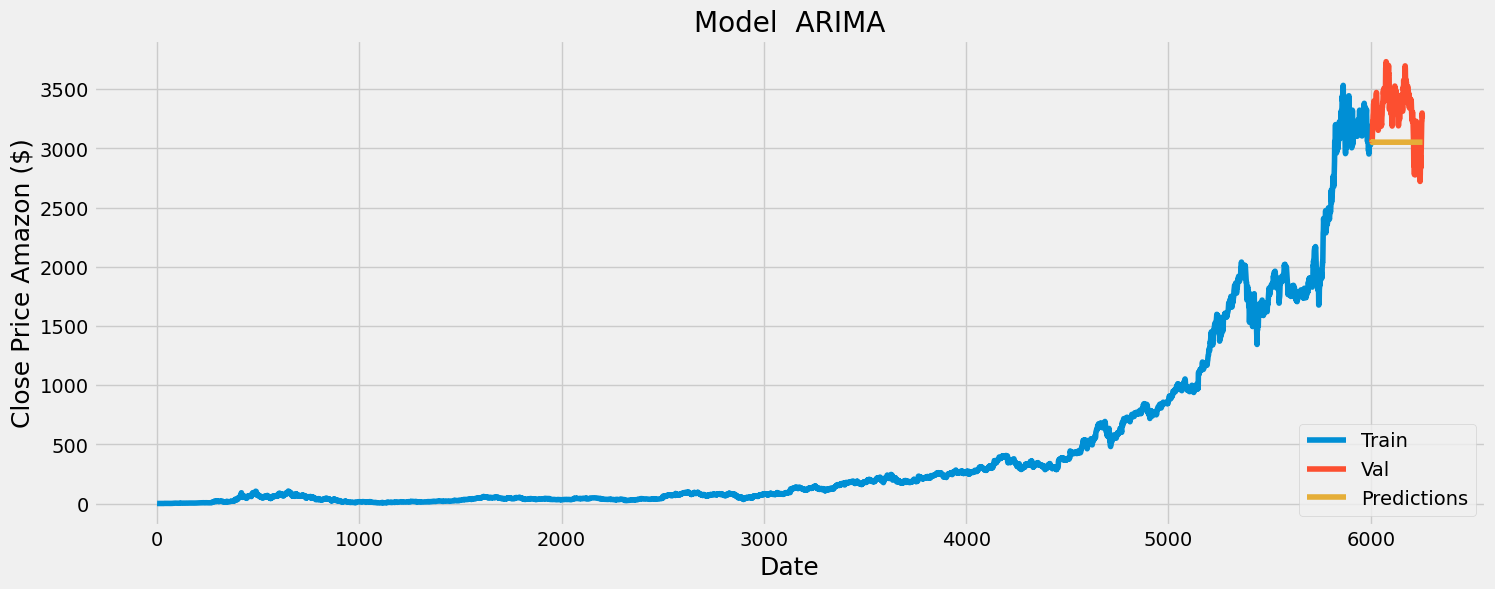

In [ ]:
train = data[:len(train_data)]
valid = data[len(train_data)+1:]
valid['PredictionsARIMA'] = forecast_values
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model  ARIMA')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Amazon ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'PredictionsARIMA']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Bibliographie


https://vu-business-analytics.github.io/internship-office/papers/paper-dmouj.pdf  \\
https://chat.openai.com/ \\
https://medium.com/analytics-vidhya/monte-carlo-simulations-for-predicting-stock-prices-python-a64f53585662 \\
https://www.kaggle.com/datasets/varpit94/amazon-stock-data
